# Denoising Autoencoder in PyTorch
This notebook demonstrates how to build a convolutional autoencoder to remove noise from images.

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Grayscale, ToTensor
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm

## Define the Autoencoder

In [39]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        # ---------- Encoder ----------
        self.down1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.down4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # ---------- Decoder ----------
        # 1) Upsample from bottleneck: 128 -> 64
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )
        # 2) Next upsampling: (64 + skip from down3’s 64) -> 32
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(64 + 64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )
        # 3) Next upsampling: (32 + skip from down2’s 32) -> 16
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(32 + 32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )
        # 4) Final upsampling: (16 + skip from down1’s 16) -> 1
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(16 + 16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # ---------- Encode ----------
        e1 = self.down1(x)      # shape: (16, 64, 64)
        e2 = self.down2(e1)     # shape: (32, 32, 32)
        e3 = self.down3(e2)     # shape: (64, 16, 16)
        e4 = self.down4(e3)     # shape: (128, 8, 8)

        # ---------- Decode + Skip Connections ----------
        d4 = self.up4(e4)               # shape: (64, 16, 16)
        d3 = self.up3(torch.cat([d4, e3], dim=1))   # shape: (32, 32, 32)

        d2 = self.up2(torch.cat([d3, e2], dim=1))   # shape: (16, 64, 64)
        d1 = self.up1(torch.cat([d2, e1], dim=1))   # shape: (1, 128, 128)

        return d1


## Load the Images into Dataset

In [40]:
from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype
from pathlib import Path

class NoisyImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = list(Path(image_dir).glob("*.jpg"))
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = read_image(str(img_path))  # This returns a torch.Tensor
        image = convert_image_dtype(image, torch.float32)
        
        # Convert to grayscale if needed
        if image.shape[0] == 3:
            image = image.mean(dim=0, keepdim=True)
        # Use PIL instead
        image = Image.open(img_path).convert("L")  # or "L" for grayscale

        if self.transform:
            image = self.transform(image)
        return image, image


In [41]:
transform = Compose([
    transforms.Resize((128, 128)),
    Grayscale(num_output_channels=1),
    ToTensor()
])

# Dataset and DataLoader
train_dataset = NoisyImageDataset("random_images", transform=transform)
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0
)

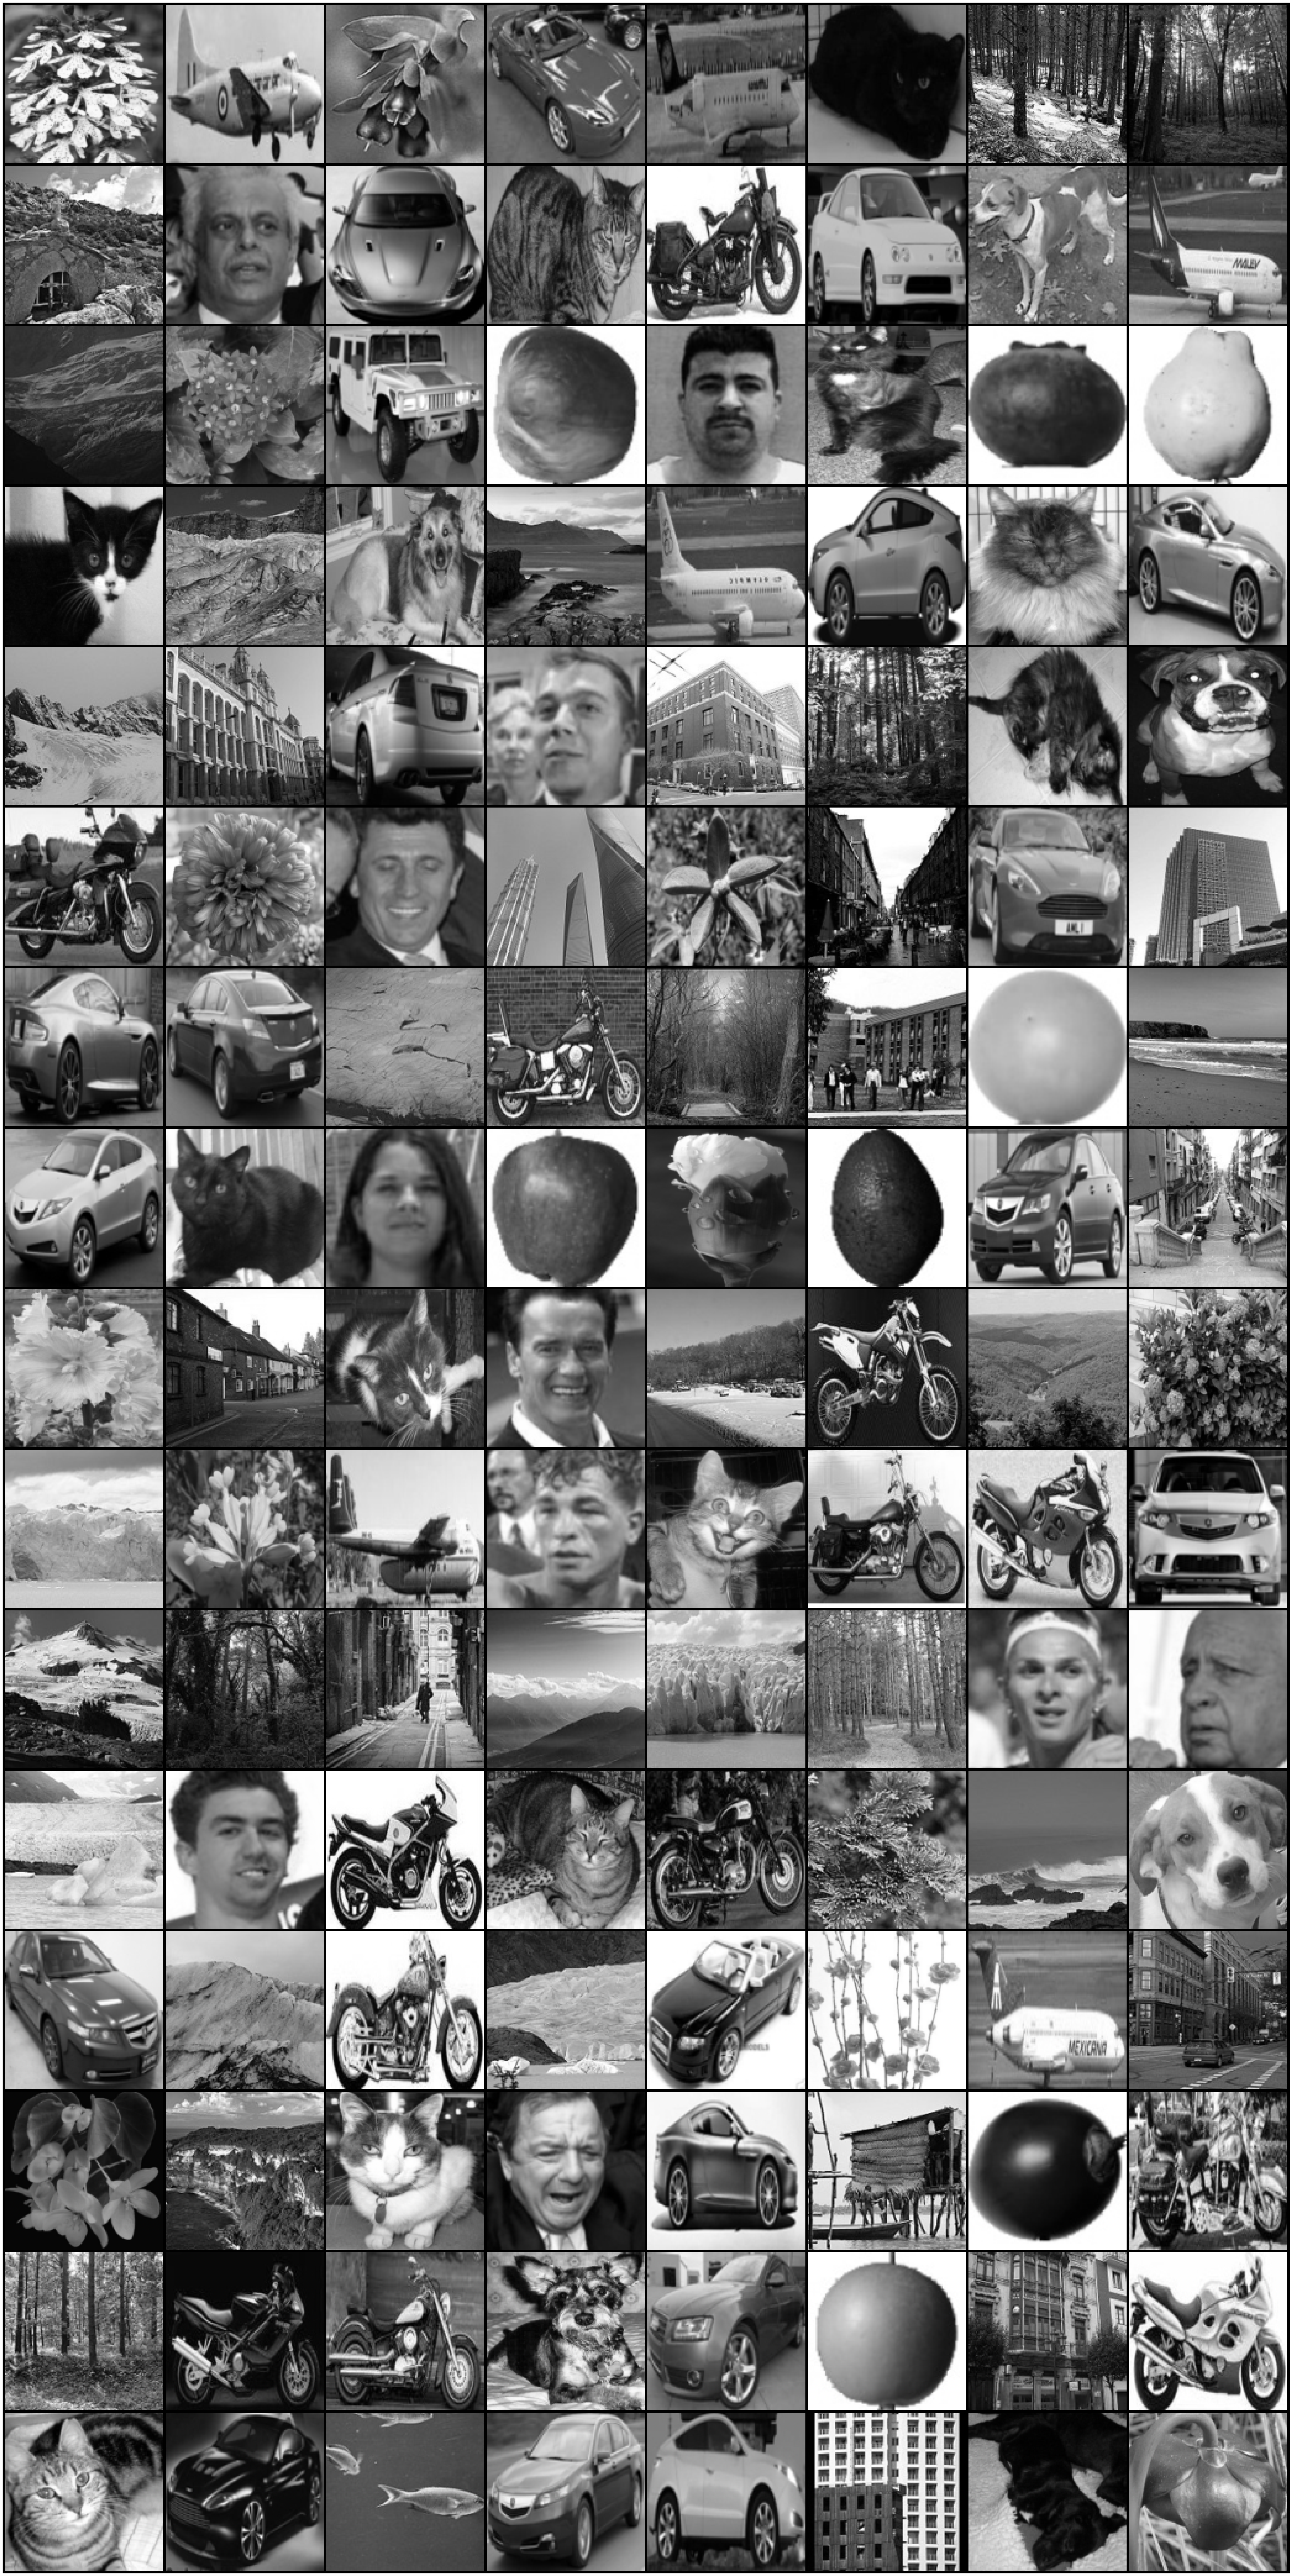

In [42]:
# Display some images from the dataset
def imshow(img, figsize):
    # Create a new figure with the given figsize
    plt.figure(figsize=figsize)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    plt.axis('off')   # optionally remove axes
    plt.show()

# Get an iterator from the DataLoader
dataiter = iter(train_loader)

# Use next to retrieve a batch
images, _ = next(dataiter)

# Visualize the batch
imshow(torchvision.utils.make_grid(images), figsize=(128, 128))


# Add Noise Function

In [43]:
def add_noise(img):
    noise_factor = 0.25
    img = img + noise_factor * torch.randn_like(img)
    img = torch.clamp(img, 0., 1.)
    return img

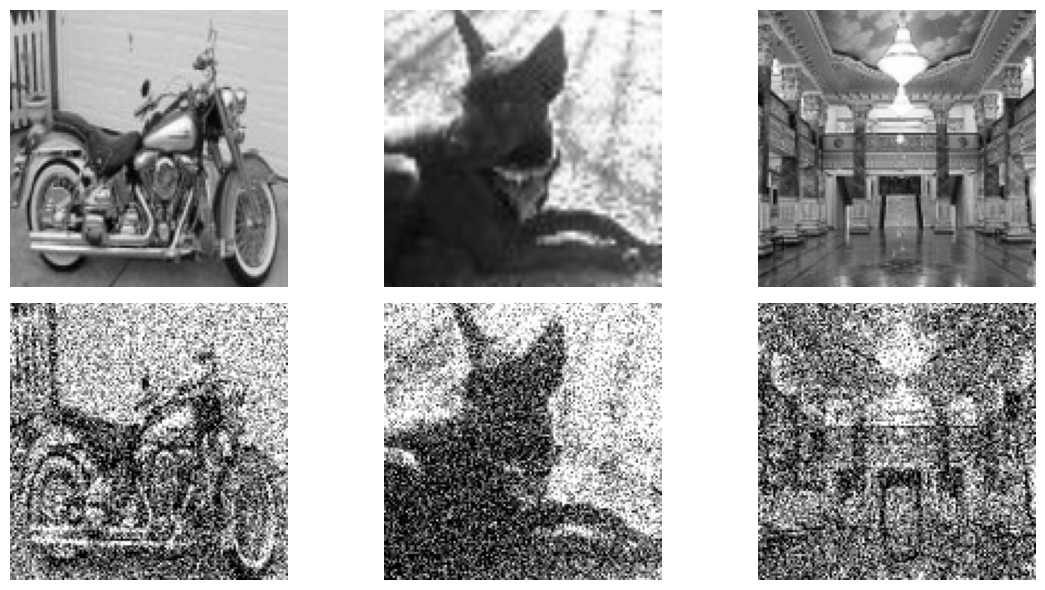

In [44]:
def show_original_vs_noisy(original, noisy, num_samples=3, figsize=(12, 6)):
    fig, axes = plt.subplots(2, num_samples, figsize=figsize)
    
    for i in range(num_samples):
        axes[0, i].imshow(original[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(noisy[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
    
    axes[0, 0].set_ylabel("Original", fontsize=14)
    axes[1, 0].set_ylabel("Noisy", fontsize=14)
    
    plt.tight_layout()
    plt.show()

test_images, _ = next(iter(train_loader))

original_subset = test_images[:3]
noisy_subset = add_noise(original_subset)

show_original_vs_noisy(original_subset, noisy_subset, num_samples=3)

## Train the Model

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() else 'cpu')
device = 'mps'
print(f'Using device : {device}')

model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
        noisy_images = add_noise(images).to(device)
        images = images.to(device)
        
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.6f}')

Using device : mps


Epoch 1/10, Loss: 0.029161


Epoch 2/10, Loss: 0.009051


Epoch 3/10, Loss: 0.007397


Epoch 4/10, Loss: 0.006645


Epoch 5/10, Loss: 0.006244


Epoch 6/10, Loss: 0.005897


Epoch 7/10, Loss: 0.005772


Epoch 8/10, Loss: 0.005581


Epoch 9/10, Loss: 0.005482


Epoch 10/10, Loss: 0.005394


## Noise Removal Demo

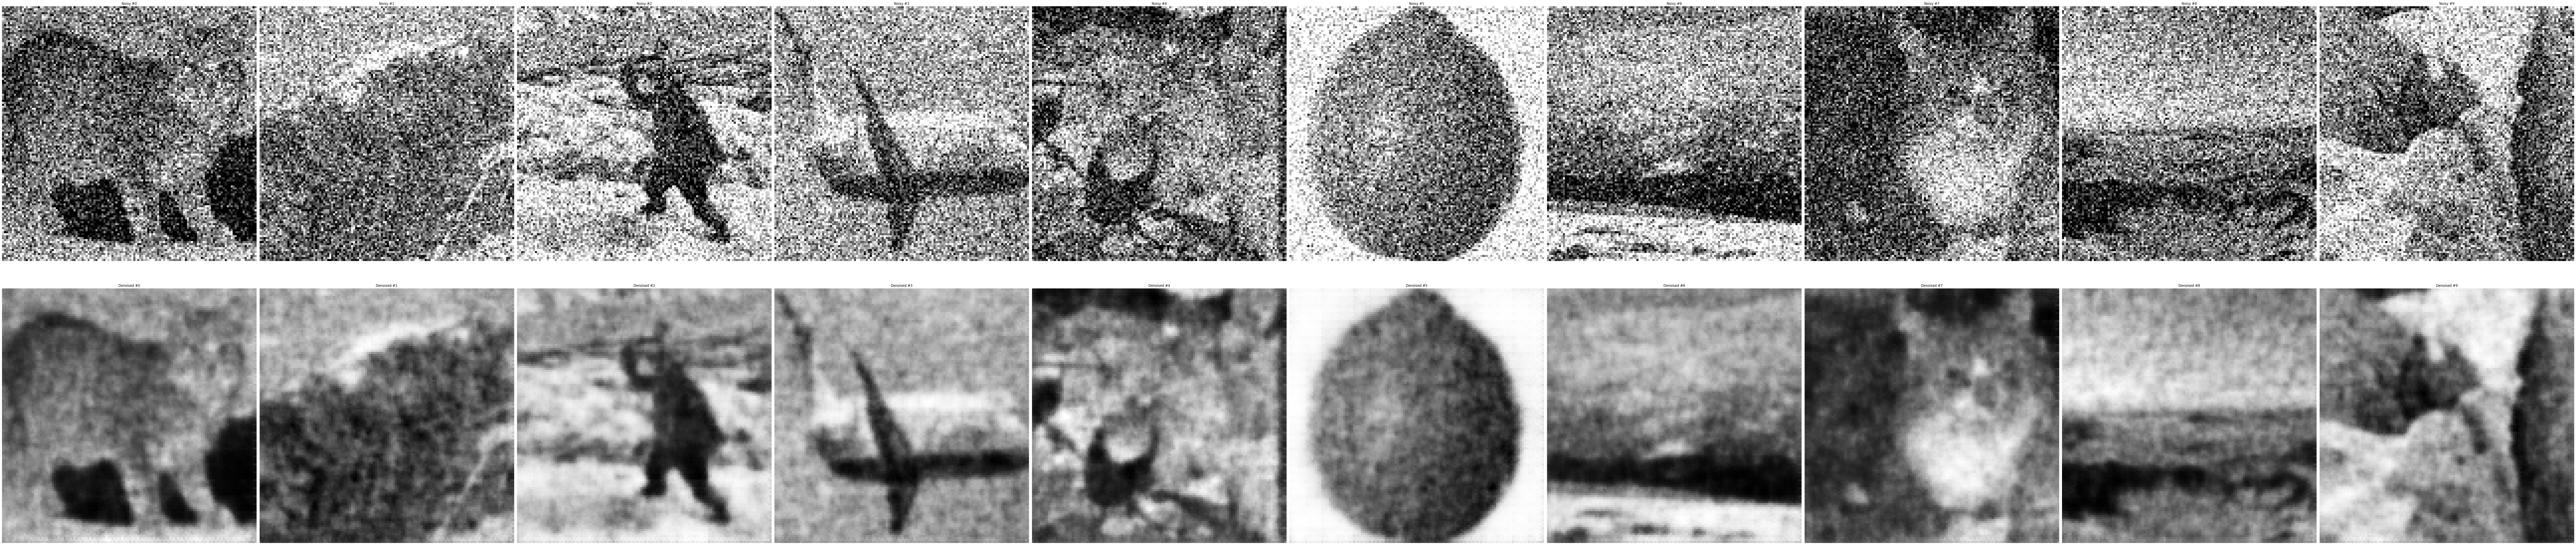

In [46]:
model.eval()
with torch.no_grad():
    # Grab a batch of test images
    test_images, _ = next(iter(train_loader))
    # Ensure at least 10 exist
    test_images = test_images[:10]
    
    # Add noise
    noisy_images = add_noise(test_images)
    noisy_images_gpu = noisy_images.to(device)
    
    # Denoise
    denoised_images = model(noisy_images_gpu).cpu()

def show_noisy_and_denoised(noisy, denoised, num_samples=10, figsize=(128, 30)):
    """
    Displays `num_samples` images in two rows:
      - Top row: noisy
      - Bottom row: denoised
    """
    fig, axes = plt.subplots(2, num_samples, figsize=figsize)
    
    for i in range(num_samples):
        # Noisy
        axes[0, i].imshow(noisy[i].squeeze(), cmap='gray')
        axes[0, i].set_title(f'Noisy #{i}')
        axes[0, i].axis('off')
        
        # Denoised
        axes[1, i].imshow(denoised[i].squeeze(), cmap='gray')
        axes[1, i].set_title(f'Denoised #{i}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show the first 10 images side by side
show_noisy_and_denoised(noisy_images, denoised_images, num_samples=10)
